In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

In [2]:
Image_Width=128
Image_Height = 128 
Image_size = (Image_Width,Image_Height)
Image_Channels = 3


In [3]:
filenames = os.listdir("./dogs-vs-cats/train")

categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
        
df = pd.DataFrame({
        'filename':filenames,
        'category':categories
})

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,Activation,BatchNormalization
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])


In [ ]:
model.summary()

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [7]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})
train_df,validate_df = train_test_split(df,test_size=0.2,random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

In [8]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   rescale = 1/255,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)
train_generator= train_datagen.flow_from_dataframe(train_df,
                                                   "./dogs-vs-cats/train/",
                                                   y_col = 'category',
                                                   target_size= Image_size,
                                                   class_mode='categorical',
                                                   batch_size=batch_size)
validation_datagen=ImageDataGenerator(rescale=1/255)
validation_generator= validation_datagen.flow_from_dataframe(validate_df,
                                                             "./dogs-vs-cats/train/",
                                                             x_col='filename',
                                                             y_col='category',
                                                             target_size=Image_size,
                                                             class_mode='categorical',
                                                             batch_size=batch_size)


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [12]:
test_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1)
test_generator = train_datagen.flow_from_dataframe(test_df,
                                                 "./dogs-vs-cats/test/",
                                                   x_col='filename',
                                                   y_col=None,
                                                   target_size=Image_size,
                                                   class_mode=None,
                                                   batch_size=batch_size)

Found 12500 validated image filenames.


In [ ]:
epochs=10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

In [11]:
test_filenames=os.listdir("./dogs-vs-cats/test")
test_df=pd.DataFrame({
    'filename':test_filenames
})
nb_samples = test_df.shape[0]

In [13]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [14]:
test_df['category'] = np.argmax(predict,axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())

test_df['category'] = test_df['category'].replace(label_map)

test_df['categpry'] = test_df['category'].replace({ 'dog':1,'cat':0})


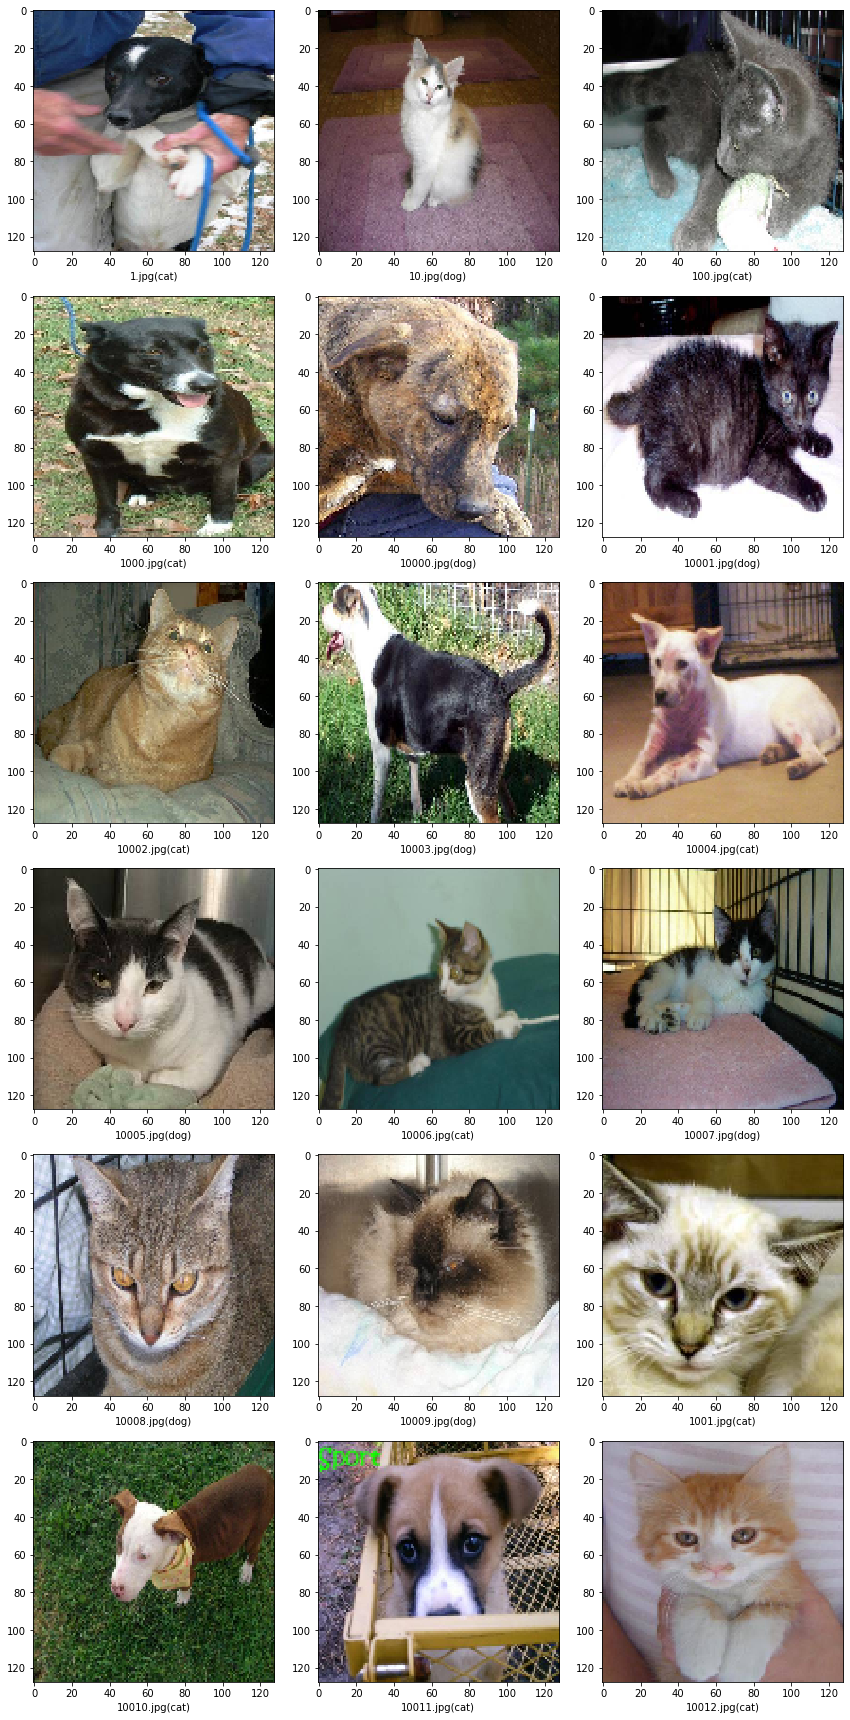

In [17]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./dogs-vs-cats/test/"+filename, target_size=Image_size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [31]:
results={
    0:'cat',
    1:'dog'
}
from PIL import Image
im=Image.open("./dogs-vs-cats/test/69.jpg")
im=im.resize(Image_size)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred=model.predict_classes([im])[0]
print(pred,results[pred])

1 dog
